# Traffic signals classification with CNN
---

### Make sure we are using GPU

In [2]:
# It should show at least a device of type "GPU"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7453265464066548301
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4945621811
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7089928281269777233
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Preprocessing image

In [3]:
import numpy as np
from skimage import color, exposure, transform

NUM_CLASSES = 43
IMG_SIZE = 48

def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # roll color axis to axis 0
    img = np.rollaxis(img, -1)
    
    return img

### Loading whole data from file or creating a file which contains whole images and labels for training

In [4]:
from skimage import io
import os, glob, h5py, random
import matplotlib.pyplot as plt

# Each training image folder contains a number which indicates the image's class/label.
def get_class(img_path):
    return int(img_path.split('\\')[-2])

try:
    # Loading pre-compiled data images and labels
    with  h5py.File('Data\\Saves\\training_data.h5') as hf: 
        X, Y = hf['imgs'][:], hf['labels'][:]
    print('Loaded images from training_data.h5\n')
    try:
        print('Example image after processing')
        r = random.randint(0, 30000)
        img = X[r]
        img = np.rollaxis(img, 0, start=3)
        plt.figure()
        imgplot = plt.imshow(img)
        plt.show()
    except Exception as e:
        print(e)
        print('It was not possible loading the image')
    
except:
    print('It was not possible to load training saved data. Generating new training_data.h5 file')
    root_dir = 'Data\\Dataset\\Training\\Images\\'
    imgs = []
    labels = []

    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    num_images = len(all_img_paths)
    print('Number of images to process:', num_images)
    for img_path in all_img_paths:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)
        # Processing progress
        if len(imgs)%4000 == 0:
            print('Processed => {:.2%}'.format(len(imgs)/num_images))

    # Images array
    X = np.array(imgs, dtype='float32')
    # Make one hot targets
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

    with h5py.File('Data\\Saves\\training_data.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

Loaded images from training_data.h5

Example image after processing


<Figure size 640x480 with 1 Axes>

### Model creation

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_first')


def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

Using TensorFlow backend.


### Model compilation

In [6]:
from keras.optimizers import SGD

model = cnn_model()
model.summary()

# Model is using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 48, 48)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 46, 46)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 23, 23)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 23, 23)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)    

### Training the model and saving it for overfitting check purposes

In [7]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Reduce the learning rate value after each epoch
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 18


try:
    print('Loading model weights')
    model.load_weights('Data\\Saves\\model-cnn.h5')
    print('Successfully loaded weigths, no training needed.')
except:
    print("It was not possible loading the weights, proceding to train")
    history = model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('Data\\Saves\\model-cnn.h5', save_best_only=True)]
          )

Loading model weights
Successfully loaded weigths, no training needed.


### Training and validation accuracy and loss (It won't work without training it)

In [8]:
# Printing history of accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

### Test images

Loaded images from test_data.h5

Example of test image after processing


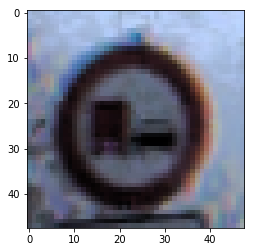

In [10]:
import pandas as pd

try:
    # Loading pre-compiled TEST data images and labels
    with  h5py.File('Data\\Saves\\test_data.h5') as hf: 
        X_test, Y_test = hf['imgs'][:], hf['labels'][:]
    print('Loaded images from test_data.h5\n')
    try:
        print('Example of test image after processing')
        r = random.randint(0, 30000)
        img = X_test[r]
        img = np.rollaxis(img, 0, start=3)
        plt.figure()
        imgplot = plt.imshow(img)
        plt.show()
    except Exception as e:
        print('It was not possible loading the test image')
except:
    test = pd.read_csv('Data\\Dataset\\GT-final_test.csv',sep=';')

    X_test = []
    Y_test = []
    print('Now starting to process test images')
    for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
        img_path = os.path.join('Data\\Dataset\\Test\\Images\\',file_name)
        X_test.append(preprocess_img(io.imread(img_path)))
        y_test.append(class_id)
        # Processing progress
        if len(X_test)%1000 == 0:
            print('Processed => {:.2%}'.format(len(X_test)/len(list(test['Filename']))))
    print('Finished processing test images')    

    X_test = np.array(X_test)
    Y_test = np.array(y_test)

    with h5py.File('Data\\Saves\\test_data.h5','w') as hf:
        hf.create_dataset('imgs', data=X_test)
        hf.create_dataset('labels', data=Y_test)

### Final model accuracy against test set

In [11]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==Y_test)/np.size(y_pred)
print("Test accuracy = {:.2%}".format(acc))

Test accuracy = 97.57%


### One pixel attack

In [12]:
from pandas.io.parsers import read_csv

signnames = read_csv('signnames.csv').values[:, 1]

def plot_image(image):
    plt.figure()
    plt.imshow(np.rollaxis(image, 0, start=3))
    plt.show() # Show the plot
    
def perturb_image(xs, img):
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            # Modify axis (48, 3, 48) -> (48, 48, 3)
            img = np.rollaxis(img, 0, start=3)
            img[x_pos, y_pos] = rgb

    return imgs

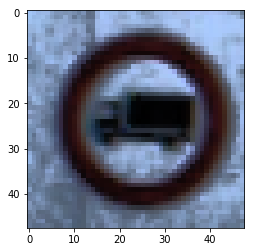

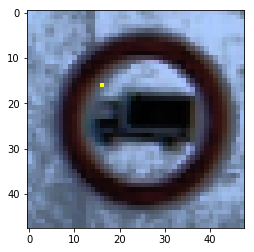

In [45]:
img = X_test[0]
plot_image(img)

pixel = np.array([16, 16, 1, 1, 0]) # Pixel with X, Y, R, G, B (RGB 0 to 1) coordinates
image_perturbed = perturb_image(pixel, img)[0]
plot_image(image_perturbed)

En el siguiente cuadro podemos comprobar que efectivamente se han modificado 3 valores de la imagen original, indicando que se han modificado los colores RGB.

In [48]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

perturbed_arr = np.array(image_perturbed)
normal_arr = np.array(np.expand_dims(X_test[0], axis=0))
print('Result=>', normal_arr - perturbed_arr)

Result=> [[[[ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.
     0.          0.          0.          0.          0

In [32]:
def predict_classes(xs, img, target_class, minimize = True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, np.expand_dims(X_test[img], axis=0))
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

In [29]:
def attack_success(xs, image, target_class,verbose=False):
    attack_image = perturb_image(xs, X_test[image])
    
    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    if verbose:
        print('Confidence:', confidence[target_class])
    if (predicted_class != target_class):
        return True

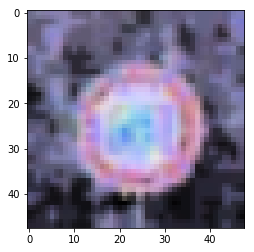

Model predicted => Speed limit (80km/h)
Prior confidence 0.9422471


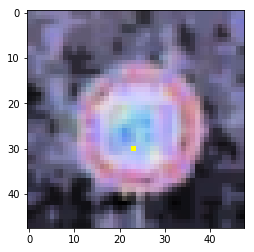

After applying a random perturbation model predicted =>  Speed limit (100km/h)
Confidence of being Speed limit (80km/h) after perturbation is => 0.23182726


Attack success: True


In [34]:
image = 931
pixel = np.array([30, 23, 1, 1, 0])
true_class = Y_test[image]

# Original image
y_pred_org = model.predict(np.expand_dims(X_test[image], axis=0))[0]
plot_image(X_test[image])

print('Model predicted =>', signnames[np.argmax(y_pred_org)])
print('Prior confidence', y_pred_org[true_class])

#Modifying image
image_perturbed = perturb_image(pixel, X_test[image])[0]
plot_image(image_perturbed)
confidence = predict_classes(pixel, image, true_class)[0]

print('After applying a random perturbation model predicted => ', signnames[np.argmax(y_pred)])
print('Confidence of being', signnames[np.argmax(y_pred_org)],'after perturbation is =>', confidence)
print('')
print('')
success = attack_success(pixel, image, true_class, verbose=False)
print('Attack success:', success == True)

### Using Scipy's implementation of differential evolution

In [35]:
from differential_evolution import differential_evolution